<a href="https://colab.research.google.com/github/zzp1012/feature-learning-ipynb/blob/main/deterministic_label_noise_feature_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
[500|500] train_loss=1.35703e-02, test_loss=2.56235e-02

In [16]:

import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional  as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from typing import Tuple

class CNN(nn.Module):
    def __init__(self,
                 m: int = 50,
                 d: int = 1000,
                 q: int = 1,
                 linear: bool = False):
        """Constructor of the CNN

        Args:
            m (int): the width of the network
            d (int): the dimension of the input
            q (int): the power degree.
            linear (bool): indicate if using linear activation.
        """
        super(CNN, self).__init__()

        self.q = q
        # flag: if use linear activation.
        self.linear = linear
        # positive neurons
        self.Wp = torch.nn.Parameter(torch.randn(d, m))
        self.Wp.requires_grad = True
        # negative neurons
        self.Wn = torch.nn.Parameter(torch.randn(d, m))
        self.Wn.requires_grad = True

        # initialize with normal distribution
        nn.init.normal_(self.Wp, std=0.001)
        nn.init.normal_(self.Wn, std=0.001)

    def act(self, input: torch.Tensor) -> torch.Tensor:
        """The customized activation function.
        """
        if self.linear:
            return input
        else:
            return torch.pow(F.relu(input),self.q)

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        """forward.
        """
        Fp = torch.mean(self.act(torch.mm(x1, self.Wp)), 1) \
            + torch.mean(self.act(torch.mm(x2, self.Wp)), 1)
        Fn = torch.mean(self.act(torch.mm(x1, self.Wn)), 1) \
            + torch.mean(self.act(torch.mm(x2, self.Wn)), 1)
        out = Fp - Fn
        return out


def prepare_data(n_train: int,
                 n_test: int,
                 dim: int,) -> Tuple[torch.Tensor]:
    """
    Prepares training and test data for a binary classification problem.

    Args:
        n_train: Number of training samples.
        n_test: Number of test samples.
        dim: Dimensionality of the data.

    Returns:
        A tuple containing the training and test labels.
    """
    assert n_train % 2 == 0 and n_test % 2 == 0, \
        "the number of samples of both test and train data must be divided by 2."

    # Label parts: first half is the positive samples and second half are the negative samples.
    train_y = torch.ones(n_train)
    train_y[n_train // 2:] = -1
    test_y = torch.ones(n_test)
    test_y[n_test // 2:] = -1

    # create the feature
    feature = torch.zeros(dim)
    feature[0] = 20

    # generate the x1 and x2
    train_x1 = feature.repeat(n_train, 1) * train_y.unsqueeze(-1) # (n_train, dim)
    test_x1 = feature.repeat(n_test, 1) * test_y.unsqueeze(-1) # (n_test, dim)
    train_x2 = torch.randn(n_train, dim)
    test_x2 = torch.randn(n_test, dim)

    # Determine the number of labels to flip
    n_flip = int(n_train * 0.1)

    # Randomly choose indices of labels to flip
    flip_indices_train = torch.randperm(n_train)[:n_flip]

    # Flip the labels at the chosen indices
    train_y[flip_indices_train] = -train_y[flip_indices_train]

    return train_x1, train_x2, train_y, test_x1, test_x2, test_y, flip_indices_train


def set_seed(seed: int):
    """set the seed
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


if __name__ == "__main__":
    # set the global parameters.
    seed = 3407
    n_train = 100
    n_test = 2000
    d = 2000
    n_epoch = 500
    bs = 250 # should be larger than n_train
    width = 20
    lr = 0.1

    # set the seed
    set_seed(seed)

    # prepare the data
    train_x1, train_x2, train_y, test_x1, test_x2, test_y, flip = prepare_data(n_train, n_test, d)
    unflip = np.setdiff1d(np.arange(n_train), flip.detach().numpy()).tolist()

    dataloader = DataLoader(
        TensorDataset(
            train_x1,
            train_x2,
            train_y
        ),
        batch_size=bs,
        shuffle=True,
    )

    # create the CNN model
    model = CNN(m=width, d=d, q=1, linear=False)

    # create the optimizer, noticing that lr is large.
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)

    sample_size = n_train

    train_loss_values = []
    test_loss_values = []
    train_acc_values = []

    train_acc_flip_values = []
    train_acc_unflip_values = []

    test_acc_values = []
    feature_learning = []
    noise_memorization_p = np.zeros((20, n_train, n_epoch))
    feature_learning_p = np.zeros((20,  n_epoch))

    noise_memorization_n = np.zeros((20, n_train, n_epoch))
    feature_learning_n = np.zeros((20,  n_epoch))

    for ep in range(n_epoch):
        train_loss = 0

        # train one epoch
        model.train()
        for sample_x1, sample_x2, sample_y in dataloader:
            # forward
            f_pred = model.forward(sample_x1, sample_x2)
            loss = torch.log(torch.exp(-f_pred * sample_y) + 1).mean()

            # set zero grad & update parameter
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update the train loss
            train_loss += sample_size * loss.item()

        model.eval()
        feature_learning_p[:, ep] =  (torch.matmul(model.Wp.T, train_x1[0])).detach().numpy()
        noise_memorization_p[:,:, ep] =  (torch.matmul(model.Wp.T, train_x2.T)).detach().numpy()

        feature_learning_n[:, ep] =  (torch.matmul(model.Wn.T, train_x1[0])).detach().numpy()
        noise_memorization_n[:,:, ep] =  (torch.matmul(model.Wn.T, train_x2.T)).detach().numpy()


        train_loss /= n_train
        train_loss_values.append(train_loss)
        f_pred_test = model.forward(test_x1, test_x2)
        f_pred_train = model.forward(train_x1, train_x2)

        pred_binary_train = (f_pred_train > 0).float() * 2 - 1
        pred_binary_test = (f_pred_test > 0).float() * 2 - 1


        correct_preds_train = (pred_binary_train == train_y).float().mean()

        correct_preds_flip_train = (pred_binary_train == train_y).float()[flip].mean()
        correct_preds_unflip_train = (pred_binary_train == train_y).float()[unflip].mean()

        correct_preds_test = (pred_binary_test == test_y).float().mean()

        train_acc_values.append(correct_preds_train.item())
        train_acc_flip_values.append(correct_preds_flip_train.item())
        train_acc_unflip_values.append(correct_preds_unflip_train.item())
        test_acc_values.append(correct_preds_test.item())

        test_loss = torch.log(torch.add(torch.exp(-f_pred_test * test_y), 1)).mean()
        test_loss_values.append(test_loss.item())

        print(f'[{ep+1}|{n_epoch}] train_loss={train_loss:0.5e}, test_loss={test_loss:0.5e}')


[1|500] train_loss=6.93370e-01, test_loss=5.12847e-01
[2|500] train_loss=5.36690e-01, test_loss=4.05799e-01
[3|500] train_loss=4.50734e-01, test_loss=3.37356e-01
[4|500] train_loss=3.98517e-01, test_loss=2.90864e-01
[5|500] train_loss=3.64251e-01, test_loss=2.57717e-01
[6|500] train_loss=3.40209e-01, test_loss=2.33247e-01
[7|500] train_loss=3.22358e-01, test_loss=2.14496e-01
[8|500] train_loss=3.08382e-01, test_loss=1.99737e-01
[9|500] train_loss=2.96955e-01, test_loss=1.87881e-01
[10|500] train_loss=2.87227e-01, test_loss=1.78174e-01
[11|500] train_loss=2.78740e-01, test_loss=1.70139e-01
[12|500] train_loss=2.71148e-01, test_loss=1.63341e-01
[13|500] train_loss=2.64205e-01, test_loss=1.57562e-01
[14|500] train_loss=2.57802e-01, test_loss=1.52598e-01
[15|500] train_loss=2.51822e-01, test_loss=1.48298e-01
[16|500] train_loss=2.46193e-01, test_loss=1.44508e-01
[17|500] train_loss=2.40831e-01, test_loss=1.41160e-01
[18|500] train_loss=2.35715e-01, test_loss=1.38182e-01
[19|500] train_loss

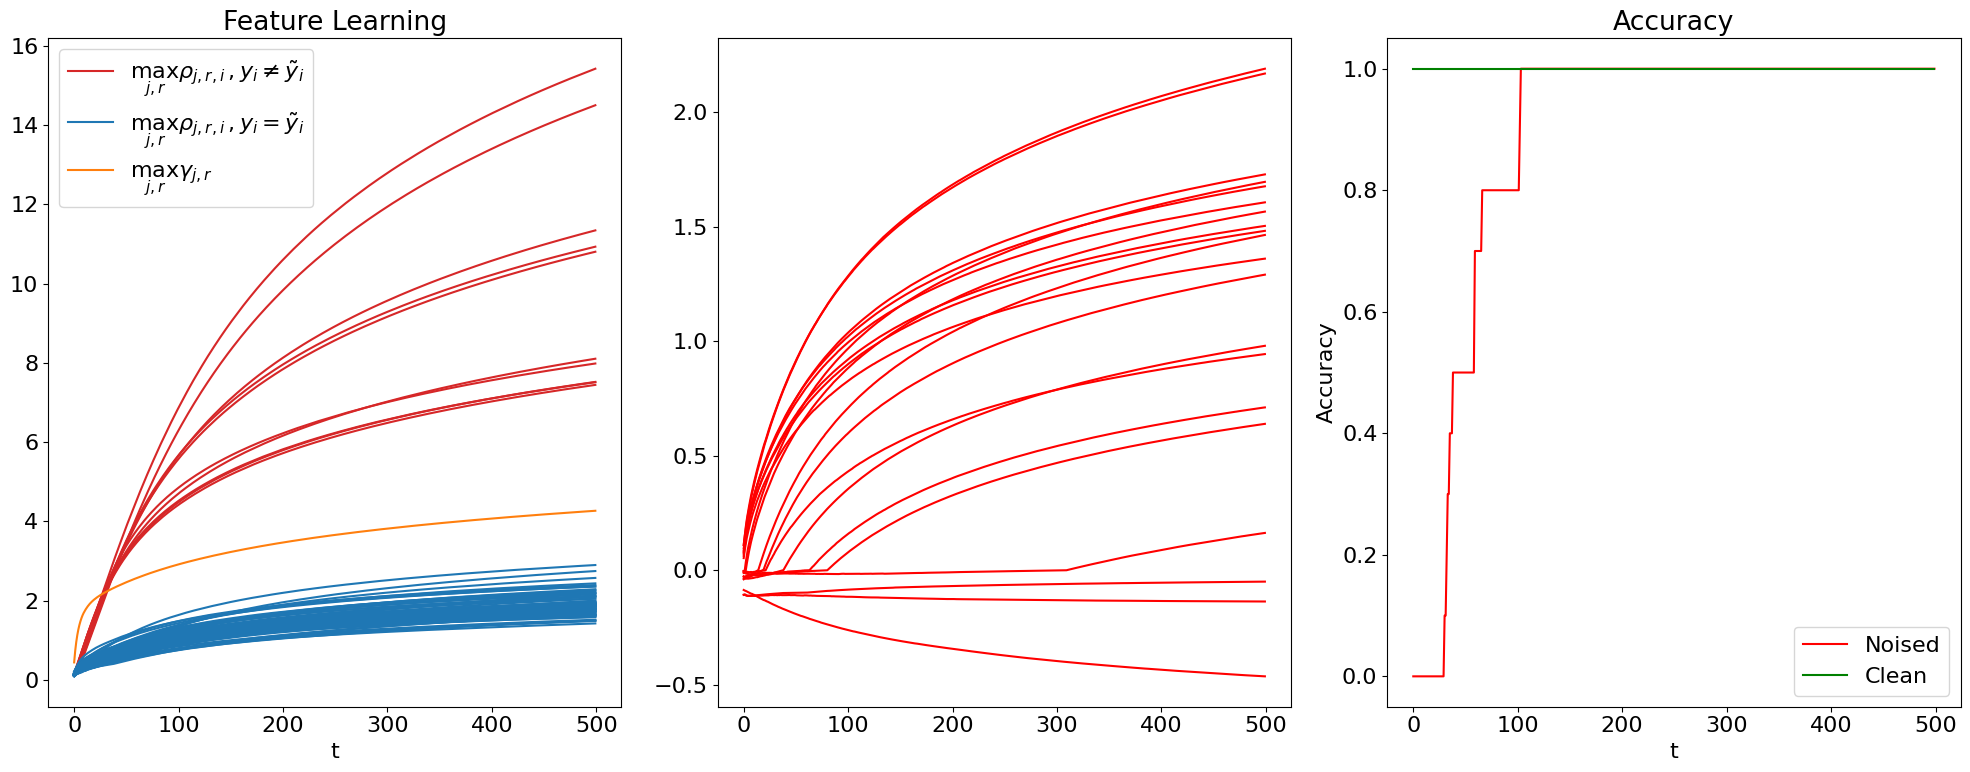

In [13]:

import random
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 16

# Create a 1x2 grid of subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

# Plot the matrix_norm_numpy values in the first subplot

feature_learning_tensor = torch.tensor(feature_learning)
feature_learning_numpy_array = feature_learning_tensor.detach().numpy()



# Convert arrays to sets
set1 = set(full_array)
set2 = set(flip.detach().numpy())

# Subtract set2 from set1
result_set = set1 - set2

# Convert back to array
unflip = list(result_set)


# Plot the loss_values in the first subplot

noise_pseris = np.max(np.abs(noise_memorization_p), axis=0)
noise_nseris = np.max(np.abs(noise_memorization_n), axis=0)
noise_mseris = np.maximum(noise_pseris, noise_nseris)

feature_pseris = np.max(np.abs(feature_learning_p), axis=0)
feature_nseris = np.max(np.abs(feature_learning_n), axis=0)
feature_mseris = np.maximum(feature_pseris, feature_nseris)


#min for overline rho
noise_overho = []
for i in range(n_train):
    if train_y[i] == 1:
        temp = np.copy(noise_memorization_p[:,i,:])
    else:
        temp = np.copy(noise_memorization_n[:,i,:])
    # set non-activated to 100 and does not affect the min
    pos_init = temp[:,0] < 0
    temp[pos_init] = 100

    noise_overho.append(temp[:,None,:])

noise_overho = np.concatenate(noise_overho, axis=1)


noise_mseris_min = np.min(np.abs(noise_overho), axis=0)
# noise_nseris_min = np.min(np.abs(noise_memorization_n), axis=0)
# noise_mseris_min = np.minimum(noise_pseris, noise_nseris)

feature_pseris_min = np.min(np.abs(feature_learning_p), axis=0)
feature_nseris_min = np.min(np.abs(feature_learning_n), axis=0)
feature_mseris_min = np.minimum(feature_pseris_min, feature_nseris_min)


tmax = 2000

ax1.plot((noise_mseris[flip[0]].T), color = 'tab:red', label = r'$\max_{j,r} \rho_{j,r,i}, y_i \neq \tilde{y}_i $' )
ax1.plot((noise_mseris[flip[1:]].T[:tmax]), color = 'tab:red')
# ax1.plot((noise_mseris_min[flip].T[:tmax]), color = 'blue' )
ax1.plot((noise_mseris[unflip[0]].T), color = 'tab:blue', label = r'$\max_{j,r} \rho_{j,r,i},y_i = \tilde{y}_i $' )
ax1.plot((noise_mseris[unflip[1:]].T[:tmax]), color = 'tab:blue')
# ax1.plot((feature_mseris_min[:tmax]), label = r'$\min_{j,r} \gamma_{j,r}$' )
ax1.plot((feature_mseris[:tmax]), label = r'$\max_{j,r} \gamma_{j,r}$' , color = 'tab:orange')

ax1.set_title('Feature Learning')
ax1.set_xlabel('t')
ax1.legend()


# ax2.plot(train_loss_values, label='train')
# ax2.plot(test_loss_values, label='test')
# ax2.set_title('Loss')
# ax2.set_xlabel('t')
# ax2.legend()


#ax1.plot((noise_mseris[flip[1]].T), color = 'red', label = r'$\max_{j,r} \rho_{j,r,i}, y_i \neq \tilde{y}_i $' )
ax2.plot((noise_memorization_p[:,17,:].T), color = 'red' )
# ax1.plot((noise_mseris_min[flip].T[:tmax]), color = 'blue' )
# # ax1.plot((noise_mseris[unflip[0]].T), color = 'green', label = r'$\max_{j,r} \rho_{j,r,i},y_i = \tilde{y}_i $' )
# # ax1.plot((noise_mseris[unflip].T[:tmax]), color = 'green')
# ax1.plot((feature_mseris_min[:tmax]), label = r'$\min_{j,r} \gamma_{j,r}$' )
# ax1.plot((feature_mseris[:tmax]), label = r'$\max_{j,r} \gamma_{j,r}$' )



ax3.plot(train_acc_flip_values, label='Noised',color = 'red')
ax3.plot(train_acc_unflip_values, label='Clean',color = 'green')
# ax3.plot(test_acc_values, label='test',color = 'black')
ax3.set_title('Accuracy')
ax3.set_xlabel('t')
ax3.set_ylabel('Accuracy')
ax3.legend()

plt.tight_layout()
plt.show()


In [ ]:
noise_mseris.shape

(100, 500)

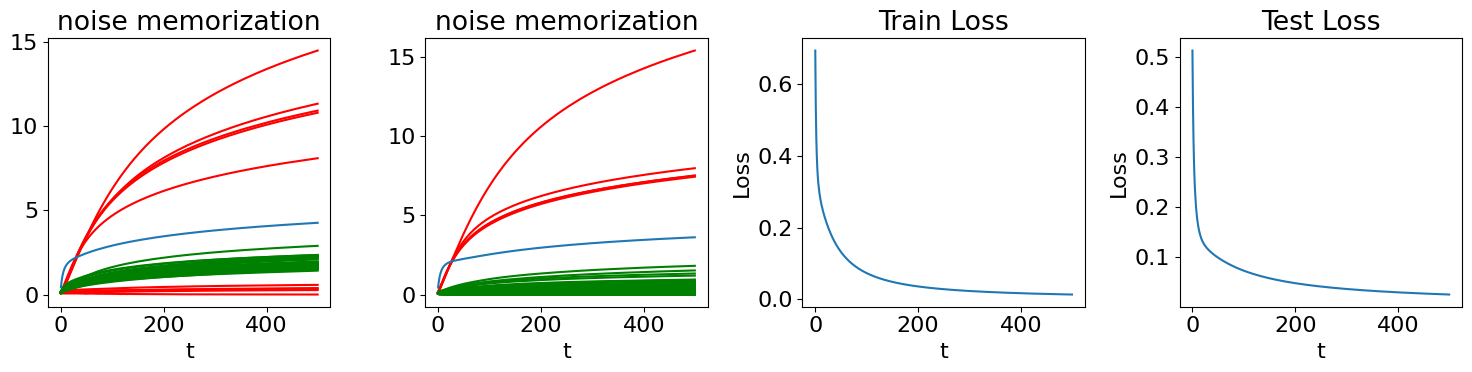

In [10]:

import random
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 16

# Create a 1x2 grid of subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))

# Plot the matrix_norm_numpy values in the first subplot

feature_learning_tensor = torch.tensor(feature_learning)
feature_learning_numpy_array = feature_learning_tensor.detach().numpy()

full_array = np.arange(50)

# Convert arrays to sets
set1 = set(full_array)
set2 = set(flip.detach().numpy())

# Subtract set2 from set1
result_set = set1 - set2

# Convert back to array
unflip = list(result_set)


# Plot the loss_values in the first subplot

ax1.plot((np.max(np.abs(noise_memorization_p), axis=0)[flip].T),color = 'red')
ax1.plot((np.max(np.abs(noise_memorization_p), axis=0)[unflip].T),color = 'green')
ax1.plot((np.max(np.abs(feature_learning_p), axis=0)))
ax1.set_title('noise memorization')
ax1.set_xlabel('t')

# Plot the loss_values in the second subplot
ax2.plot((np.max(np.abs(noise_memorization_n), axis=0)[flip].T),color = 'red')
ax2.plot((np.max(np.abs(noise_memorization_n), axis=0)[unflip].T),color = 'green')
ax2.plot((np.max(np.abs(feature_learning_n), axis=0)))
ax2.set_title('noise memorization')
ax2.set_xlabel('t')
#ax2.set_ylabel('Loss')

ax3.plot(train_loss_values)
ax3.set_title('Train Loss')
ax3.set_xlabel('t')
ax3.set_ylabel('Loss')

ax4.plot(test_loss_values)
ax4.set_title('Test Loss')
ax4.set_xlabel('t')
ax4.set_ylabel('Loss')

plt.tight_layout()
plt.show()



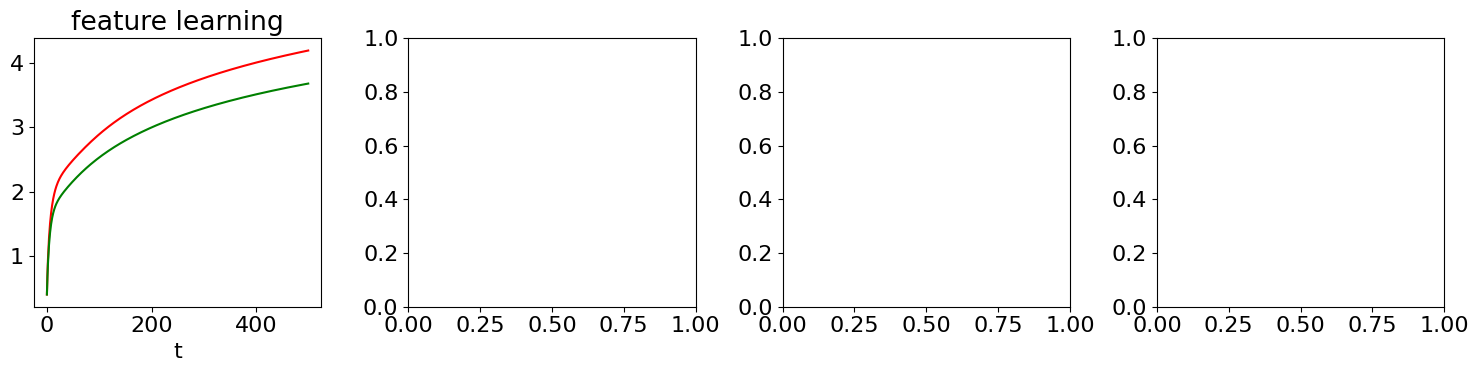

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 16

# Create a 1x2 grid of subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))


# Plot the loss_values in the first subplot

ax1.plot(abs(feature_learning_n.mean(axis=0)),color = 'red')
ax1.plot(abs(feature_learning_p.mean(axis=0)),color = 'green')
# ax1.plot((np.max(np.abs(feature_learning_p), axis=0)))
ax1.set_title('feature learning')
ax1.set_xlabel('t')



plt.tight_layout()
plt.show()


In [ ]:
feature_learning_n

array([[-0.37277317, -0.68656516, -0.92531145, ..., -4.20174932,
        -4.20349121, -4.20517302],
       [-0.44473973, -0.75591183, -0.99417859, ..., -4.3074913 ,
        -4.30922556, -4.31098366],
       [-0.42928076, -0.73948324, -0.97553468, ..., -4.21760416,
        -4.21930456, -4.22100735],
       ...,
       [-0.42861548, -0.73895824, -0.97576976, ..., -4.19299316,
        -4.19468212, -4.19635677],
       [-0.37302631, -0.68517506, -0.92141354, ..., -4.18974304,
        -4.19141006, -4.19314575],
       [-0.33503038, -0.64320493, -0.87863237, ..., -4.17027521,
        -4.17200947, -4.17372465]])

In [ ]:
import numpy as np

print(1/ (1+np.exp(0.3-1.11)))

0.6921095043017882


In [ ]:
1/0.83

1.2048192771084338

In [ ]:
import numpy as np

tau = 0.1

0.247*tau/(0.5*(1-tau))

0.05488888888888889

In [ ]:
0.3*0.42-0.2*0.55

0.015999999999999986

In [ ]:
0.45*0.1 - 0.05*0.8

0.0049999999999999975

In [ ]:
# simulation

T_1 = [0.01, 0.1, 0.5, 0.8, 1, 2]

taus = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.45]
snrs = [0.001, 0.1, 0.2, 0.5, 1, 2, 3]
p_ratios = [0.1, 0.5, 1, 2]


s_pairs = []
for tau in taus:
    for snr in snrs:
        for p_ratio in p_ratios:
